# Automated Correlation-Based Stock Classification with Machine Learning Forecasting




In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import utils.ticker_manipulation as tm
import utils.correlations as cor
import utils.grouping as grouping
import csv
import time
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [36]:
ticker_list = ['KO', 'MDB', 'BAC', 'BLK', 'SYK', 'MRK', 'AAL', 'PINS', 'LOW', 'DAL', 'SHW', 'LLY', 'ASML', 'UNH', 'PSX', 'CRM', 'HSY', 'AFRM', 'CHTR', 'PCAR', 'DECK', 'SPGI', 'RHHBY', 'SHOP', 'WFC', 'CVX', 'ABBV', 'BMY', 'AEP', 'PYPL', 'JNJ', 'AXP', 'NVS', 'YUM', 'MSCI', 'ECL', 'MDLZ', 'HCA', 'SBUX', 'UAL', 'CHD', 'KMI', 'XOM', 'CVS', 'GILD', 'HLT', 'QSR', 'LHX', 'GOOGL', 'SLB', 'DDOG', 'VWAGY', 'EQNR', 'AMD', 'VALE', 'COST', 'AMAT', 'GE', 'WMT', 'NVDA', 'NOW', 'TCEHY', 'D', 'COP', 'JD', 'ELV', 'IQV', 'CBOE', 'RIO', 'SAP', 'SCHW', 'LYV', 'TDOC', 'NEE', 'SO', 'ROST', 'MKC', 'STLD', 'CRWD', 'MS', 'DVN', 'PCG', 'HON', 'APD', 'GS', 'REGN', 'KHC', 'INFY', 'BIDU', 'SRE', 'TTE', 'CSCO', 'NET', 'CMCSA', 'ADDYY', 'MAR', 'NFLX', 'SNOW', 'CZR', 'APA', 'GM', 'SNAP', 'NDAQ', 'META', 'NUE', 'EW', 'VLO', 'VRTX', 'HES', 'AZN', 'MSFT', 'BA', 'ADBE', 'SPOT', 'V', 'BHP', 'CCL', 'BSX', 'NTES', 'BKNG', 'TSLA', 'LMT', 'ZS', 'K', 'F', 'TJX', 'SKX', 'T', 'SEDG', 'BEP', 'SPWR', 'DOW', 'NOC', 'IBM', 'UL', 'BYD', 'LCID', 'TM', 'ETN', 'LVMUY', 'MCD', 'WYNN', 'CLX', 'C', 'PENN', 'DUK', 'FI', 'BABA', 'WBD', 'AMGN', 'ENPH', 'ADSK', 'EL', 'AVGO', 'RCL', 'MA', 'DG', 'SHEL', 'LIN', 'X', 'QCOM', 'TMO', 'PEG', 'MPC', 'OXY', 'EMR', 'DD', 'FCX', 'HD', 'CL', 'RTX', 'PPG', 'GPN', 'MDT', 'INTU', 'GD', 'FANG', 'ETSY', 'AAPL', 'WMB', 'PM', 'ROKU', 'INTC', 'ZBH', 'TSM', 'CAT', 'PFE', 'LRCX', 'VZ', 'RIVN', 'MGM', 'ACN', 'DOV', 'HRL', 'CMI', 'MU', 'KLAC', 'PARA', 'DPZ', 'KMB', 'PLTR', 'DE', 'ICE', 'BP', 'AMZN', 'DLTR', 'AA', 'PG', 'FSLR', 'ABNB', 'OKTA', 'GIS', 'TDG', 'EIX', 'UBER', 'DOCU', 'EXC', 'DIS', 'UAA', 'TGT', 'WIT', 'ISRG', 'ED', 'HAL', 'PEP', 'WDAY', 'RUN', 'EPAM', 'BKR', 'LYFT', 'TMUS', 'PDD', 'NKE', 'ORCL', 'NEM', 'JPM', 'LULU', 'PANW', 'MO', 'EOG', 'FTNT', 'MRNA', 'IR', 'CME', 'ULTA', 'LYB', 'EQIX']

test_tickers=['ASML', 'AMAT', 'LRCX', 'KLAC','COP', 'DVN', 'APA', 'FANG', 'EOG']

In [37]:
#Config

#list dates to map for
start_date = "2020-01-01"
end_date = "2025-06-12"
#end_date=dt.now().strftime("%Y-%m-%d")

# --- EWMA Configuration ---
# 'span' determines the decay. A smaller span means faster decay and more weight to recent data.
# Common values: 20 (approx. 1 month), 60 (approx. 3 months).
ewma_span = 720 # You can adjust this value based on how much you want to prioritize recent data

#this values is the minimum correlation required for any value to be added to a group
#this correlation can be between it and any value in the group, does not require all values
grouping_minimum_correlation=0.85

In [38]:
all_dict=tm.get_tickers_data(test_tickers,start_date,end_date)

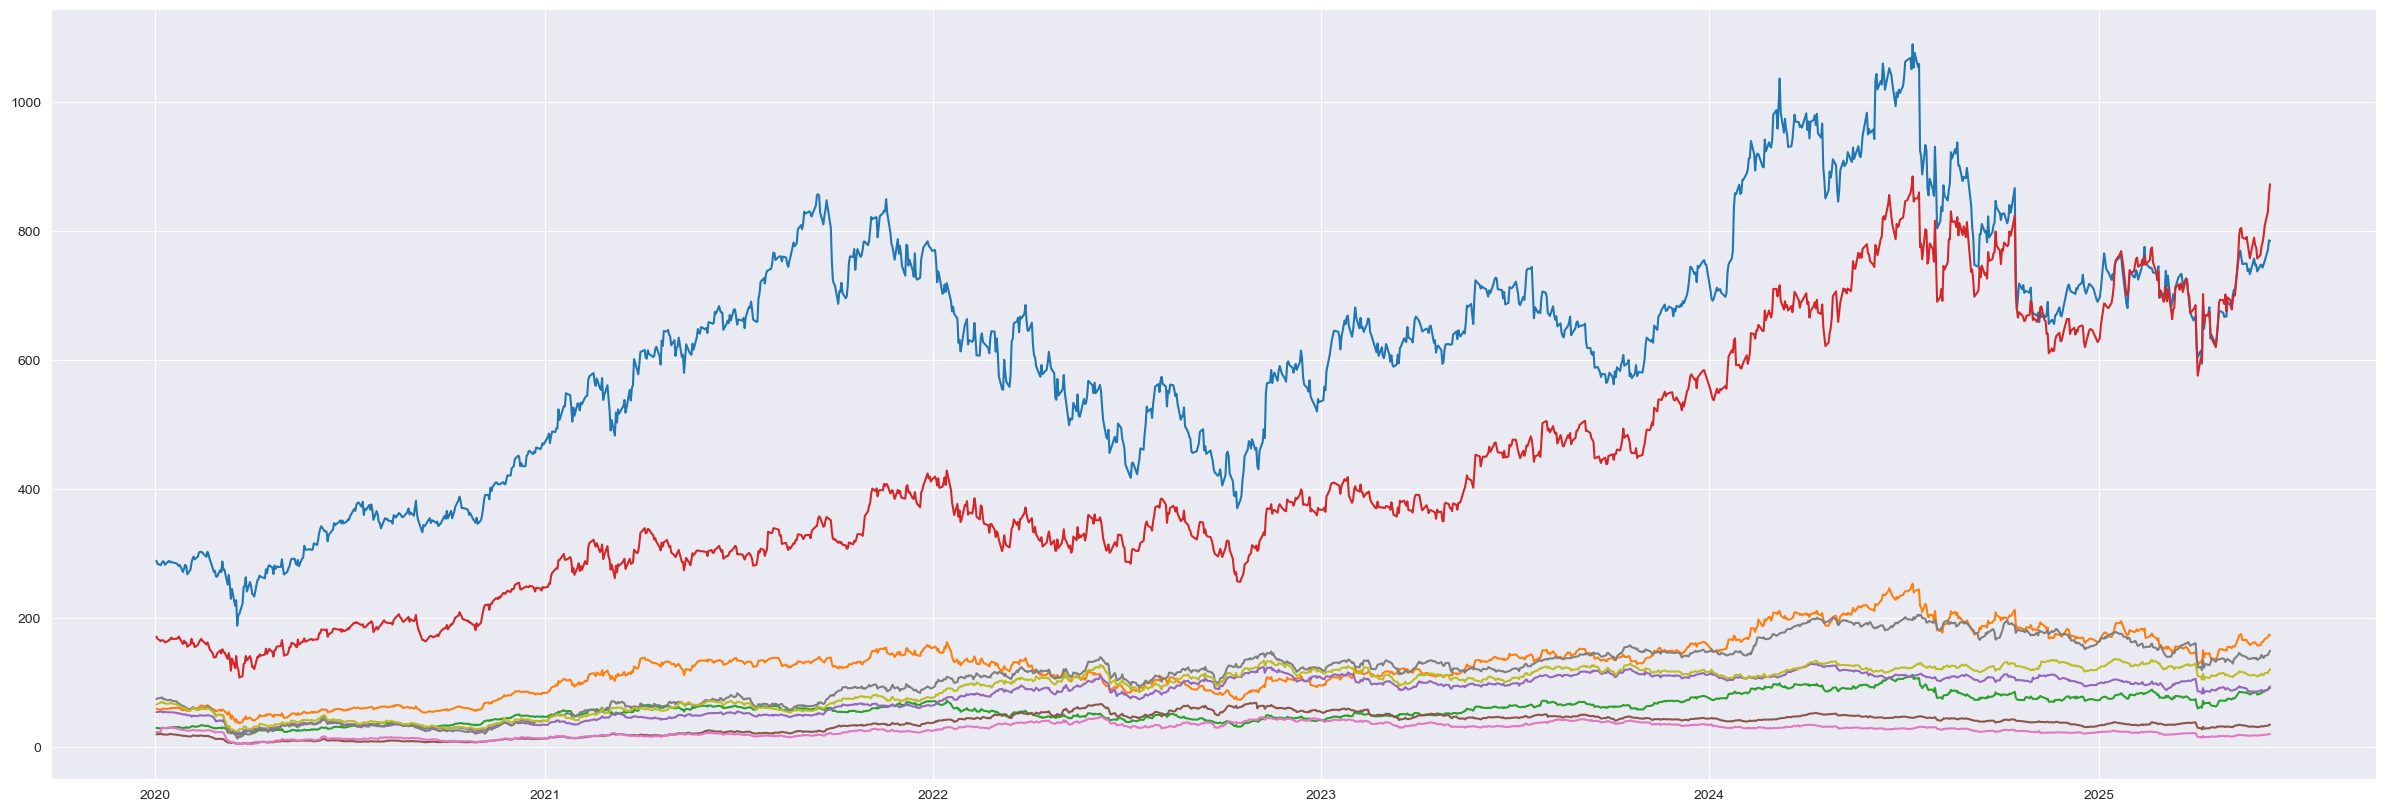

In [39]:
tm.plot_tickers_values(all_dict)

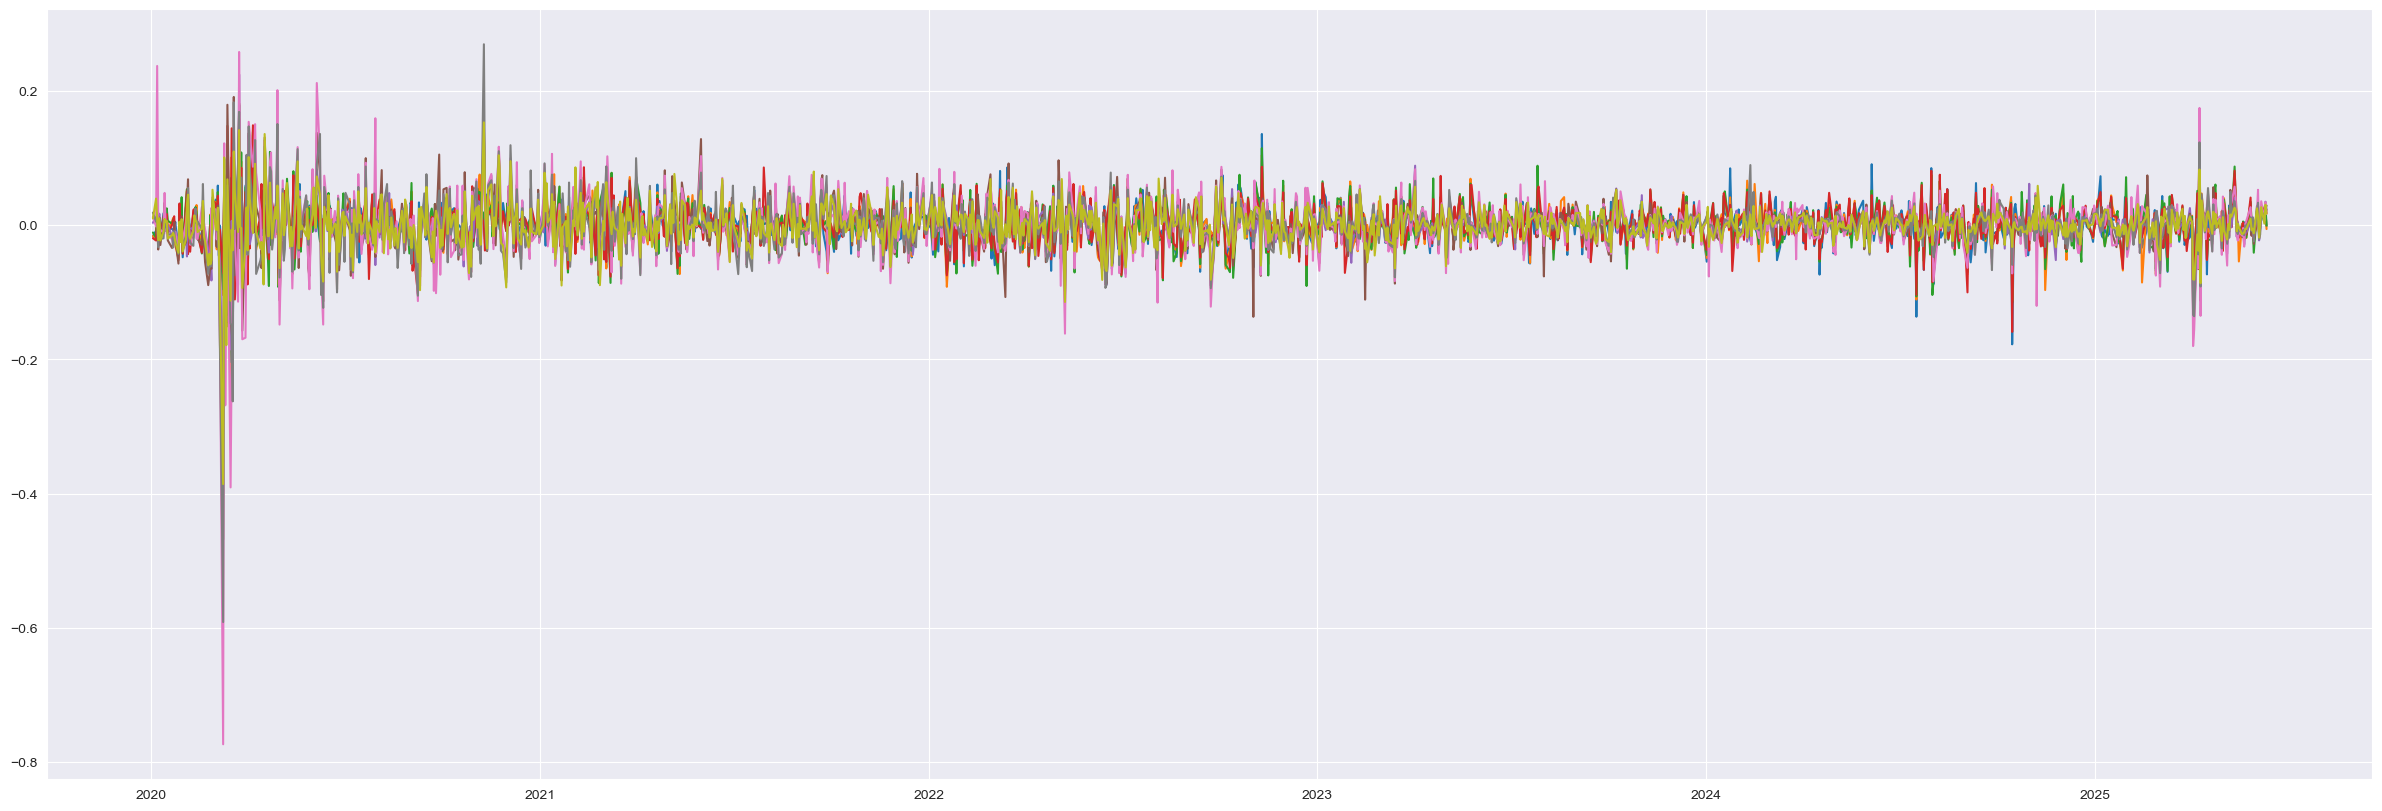

In [40]:
df_returns=tm.plot_tickers_return(all_dict)

# Exploring Correlation Methods

### Pearson Correlation
Linear correlation that measures the strength and direction of a linear relationship between two variables.<br>
**Use in stocks:** Not ideal on its own; it gives equal weight to all data points, so it doesn’t capture recent dynamics or handle outliers well.

---
### Spearman Correlation
Rank-based correlation that assesses how well the relationship between two variables can be described using a monotonic function.<br>
**Use in stocks:** More robust to outliers and useful for capturing consistent directional relationships, even if not linear.

---
### EWMA Correlation
Exponentially Weighted Moving Average correlation that gives more weight to recent data points.<br>
**Use in stocks:** Very useful for tracking changing relationships over time, especially in volatile markets.

---
### Rolling Window Correlation
Computes correlation over a sliding window of time, capturing localized relationships.<br>
**Use in stocks:** Good for observing short-term changes in correlation, particularly useful in backtesting strategies.

---
### Additional Methods Explored

**Kendall Tau Correlation** – Rank-based correlation like Spearman but with a different calculation; slower and more niche, useful for small datasets.<br>
**Partial Correlation** – Measures the relationship between two variables while controlling for others; useful when filtering out confounding effects.<br>
**Distance Correlation** – Captures both linear and nonlinear relationships; detects hidden dependencies but not limited to -1 to 1 range.<br>
**Mutual Information** – Measures how much information one variable gives about another; useful in machine learning and nonlinear analysis.<br>
**Copula-Based Correlation** – Captures dependency structures in the tails of distributions; valuable for modeling extreme events and risk.



In [41]:
# --- Calculate Exponentially Weighted Moving Average (EWMA) Correlation Matrix ---
# This gives more weight to recent values.
# The `span` parameter determines the decay rate.
# .corr() on the EWM object computes the EWMA correlation matrix.
# We then take the last complete correlation matrix from the multi-indexed result.
ewma_corr_df = df_returns.ewm(span=ewma_span).corr()

# Get the most recent EWMA correlation matrix
# df_returns.index[-1] gets the last date in your returns DataFrame.
correlation_matrix = ewma_corr_df.xs(df_returns.index[-1], level=0)

## Visualing correlation using a heatmap

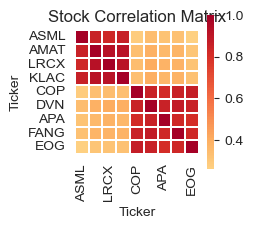

In [42]:
cor.map_correlations(correlation_matrix)

In [51]:
final_groups=grouping.grouping(grouping_minimum_correlation,correlation_matrix,2)

print(final_groups)
for group in final_groups:
    temp=""
    for ticker in group:
        temp=f"{temp}\n{ticker} = {yf.Ticker(ticker).info['longName']}"
    print(temp,"\n")

[['ASML', 'AMAT', 'LRCX', 'KLAC'], ['COP', 'DVN', 'APA', 'FANG', 'EOG']]

ASML = ASML Holding N.V.
AMAT = Applied Materials, Inc.
LRCX = Lam Research Corporation
KLAC = KLA Corporation 


COP = ConocoPhillips
DVN = Devon Energy Corporation
APA = APA Corporation
FANG = Diamondback Energy, Inc.
EOG = EOG Resources, Inc. 



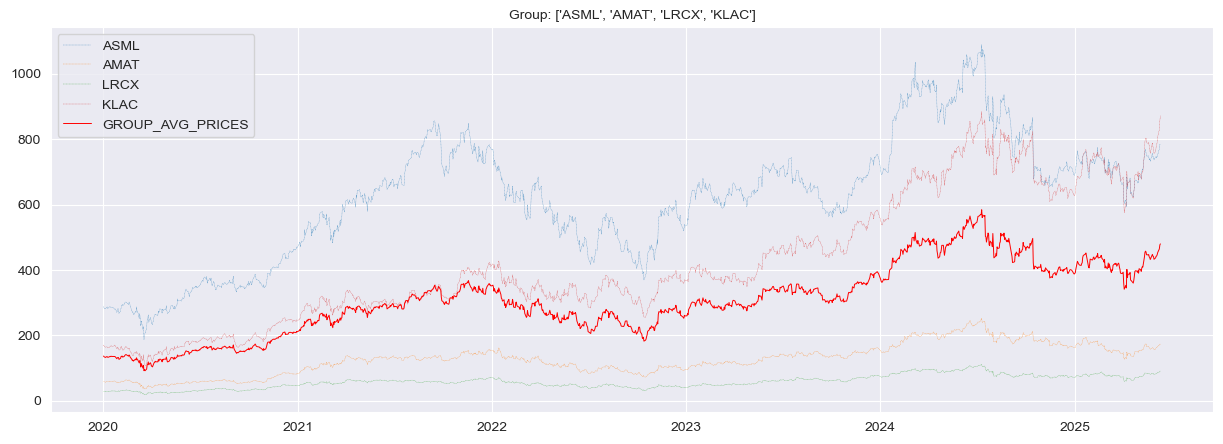

KLAC vs GROUP_EWM_AVG (excluding KLAC): 0.944,  KLA Corporation
LRCX vs GROUP_EWM_AVG (excluding LRCX): 0.993,  Lam Research Corporation
AMAT vs GROUP_EWM_AVG (excluding AMAT): 0.998,  Applied Materials, Inc.
ASML vs GROUP_EWM_AVG (excluding ASML): 0.950,  ASML Holding N.V.

intergroup correlation:0.88450


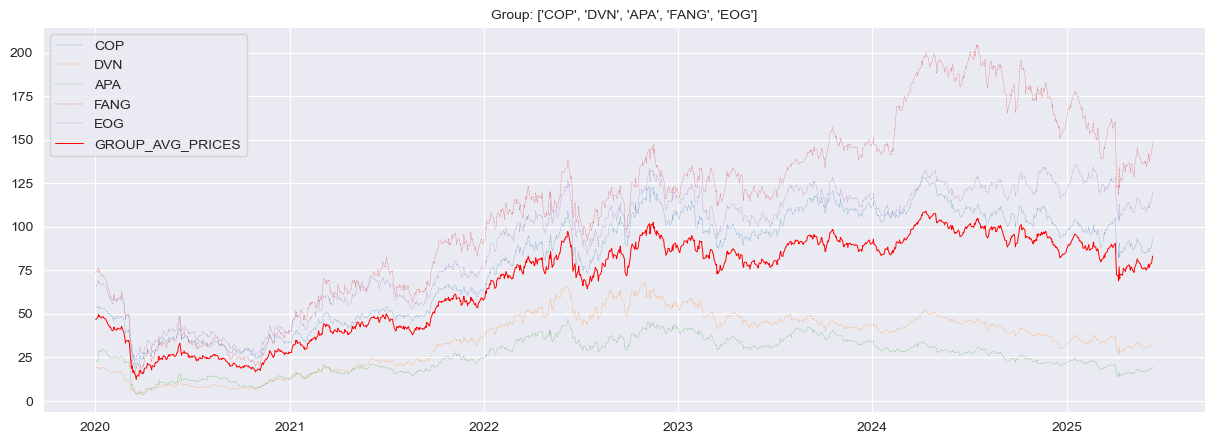

EOG vs GROUP_EWM_AVG (excluding EOG): 0.999,  EOG Resources, Inc.
FANG vs GROUP_EWM_AVG (excluding FANG): 0.978,  Diamondback Energy, Inc.
APA vs GROUP_EWM_AVG (excluding APA): 0.933,  APA Corporation
DVN vs GROUP_EWM_AVG (excluding DVN): 0.957,  Devon Energy Corporation
COP vs GROUP_EWM_AVG (excluding COP): 0.997,  ConocoPhillips

intergroup correlation:0.84389


In [44]:
for group in final_groups:
    plt.figure(figsize=(15, 5))  # Create a new figure for each group

    # Step 1: Get closing prices for all stocks in this group
    group_closes = pd.DataFrame()
    for stock in group:
        group_closes[stock] = all_dict[stock]['Close']
        plt.plot(group_closes[stock], label=stock, linestyle='dashed', linewidth=0.2)

    # Step 2: Calculate daily average across all stock prices
    group_avg_prices = group_closes.mean(axis=1)

    # Step 3: Plot the average prices
    plt.plot(group_avg_prices, label='GROUP_AVG_PRICES', linewidth=0.7, color='red')

    # Step 4: Make it look nice
    plt.title(f'Group: {group}',size=10)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Calculate correlation using EWM smoothed prices
    print_stats = ""
    for stock in group:
        # Apply EWM to individual stock prices first
        stock_ewm = group_closes[stock].ewm(span=ewma_span).mean()

        # Create group EWM average excluding the current stock
        other_stocks = [s for s in group if s != stock]
        other_prices_ewm = group_closes[other_stocks].ewm(span=ewma_span).mean()
        group_avg_excluding_stock = other_prices_ewm.mean(axis=1)

        # Correlate EWM-smoothed stock prices with EWM-smoothed group average
        corr_with_avg = stock_ewm.corr(group_avg_excluding_stock)
        print_stats = (f"{stock} vs GROUP_EWM_AVG (excluding {stock}): {corr_with_avg:.3f},  "
                       f"{yf.Ticker(stock).info['longName']}\n{print_stats}")

    print(print_stats)

    group_corr_matrix = correlation_matrix.loc[group, group]
    # Get upper triangle (avoid counting each pair twice)
    avg_corr = group_corr_matrix.where(np.triu(np.ones_like(group_corr_matrix, dtype=bool), k=1)).stack().mean()
    print(f"intergroup correlation:{avg_corr:.5f}")